# Discussion upvotes: how long till the medal?


Not every upvote of your Discussion message/topic counts towards medals: 

> votes by novices are excluded from the medal calculation*. 

**The script helps to identify the number of upvotes of a discussion message counted towards a medal.**

**You can check your own or anybody else discussion message/topic. Dive into your discussion effectiveness!**

\* votes on old posts are also excluded from the medal calculation, but the script doesn't do this check.

\** there probably a 1-2 day lag in the amount of upvotes you see since the database is updated by kaggle on a daily basis.

\*** Before running the script insure that "Meta Kaggle" dataset is added via Add dataset->Datasets->Search for "Meta Kaggle" (Every time Kaggle updates the database, it deletes the previous one and it is no longer available).

# Parameters to enter

In [1]:
# Put any user name (your user name, for example) to count the upvotes
# It is in the final part of the profile url: https://www.kaggle.com/darbin
user_name = 'darbin'

# Count "not novices" upvotes

## - Setup

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import os
#print(os.listdir("../input"))
pd.set_option('display.max_columns', None)

Users = pd.read_csv('../input/Users.csv').rename(columns = {'Id': 'UsersId'})
ForumMessages = pd.read_csv('../input/ForumMessages.csv').rename(columns = {'Id': 'ForumMessagesId'})
ForumMessageVotes = pd.read_csv('../input/ForumMessageVotes.csv').rename(columns = {'Id': 'ForumMessageVotesId'})
ForumTopics = pd.read_csv('../input/ForumTopics.csv').rename(columns = {'Id': 'ForumTopicsId'})

user_id = float(Users[Users.UserName == user_name]['UsersId'])
user_messages_ids = ForumMessages[ForumMessages.PostUserId == user_id]['ForumMessagesId']

## - Table of messages effectiveness

In [3]:
# 'CountedUpvotes' is the target - this is the number of users who are not Novices

# result table
message_upvotes = pd.DataFrame(
    columns = ['MessageId',
               'DiscussionTopic', # Forum topic the message is attached to
               'Message', # Message being evaluated
               'DiscussionTopic-Message', # concatenation of 'DiscussionTopic' and 'Message'
               'CountedUpvotes', # novices upvotes are excluded
               'TotalUpvotes', # total upvotes
               'RemainedUpvotes_Bronze', # How long till a bronze = 1 - CountedUpvotes
               'RemainedUpvotes_Silver', # How long till a silver = 5 - CountedUpvotes
               'RemainedUpvotes_Gold' # How long till a gold = 10 - CountedUpvotes
                ])

for i, message_id in enumerate(user_messages_ids):
    message = str(ForumMessages[ForumMessages.ForumMessagesId == message_id]['Message'])
    message = message.split(' <p>') # remove index and <p>
    if(len(message) == 0): message = str('')
    if(len(message) > 1): 
        message = str(message[1])
        message = message.split('</p>')[0] # remove final '</p>'
        message = message.split('\nName: Message, dtype: object')[0] # remove the final '\nName: Message, dtype: object'
        message = str(message)
    
    topic_id = float(ForumMessages[ForumMessages.ForumMessagesId == message_id]['ForumTopicId'])
    topic = ForumTopics[ForumTopics.ForumTopicsId == topic_id]['Title']
    if(len(topic) == 0):
        topic = str('')
    else:
        topic = str(topic)
        topic = topic.split('    ')[1] # remove index
        topic = topic.split('\n')[0] # remove final '\n'
        topic = str(topic)
    
    users_id_upvoted_message = ForumMessageVotes[ForumMessageVotes.ForumMessageId == message_id]['FromUserId']

    if(users_id_upvoted_message.count() == 0):
        total_upvotes_count = 0
        counted_upvotes_count = 0
    else:
        total_upvotes_count = users_id_upvoted_message.count()
        # upvotes which are counted for a medal
        counted_upvotes_count = Users[Users.UsersId.isin(users_id_upvoted_message) 
                                 & (Users.PerformanceTier > 0) 
                                 & (Users.UsersId != user_id)]['UsersId'].count()

    message_upvotes.loc[ i, 'MessageId'] = message_id
    message_upvotes.loc[ i, 'DiscussionTopic'] = topic
    message_upvotes.loc[ i, 'Message'] = message
    message_upvotes.loc[ i, 'DiscussionTopic-Message'] = str(topic) + " (\"" + str(message) + "\")"
    message_upvotes.loc[ i, 'CountedUpvotes'] = counted_upvotes_count
    message_upvotes.loc[ i, 'TotalUpvotes'] = total_upvotes_count
    message_upvotes.loc[ i, 'RemainedUpvotes_Bronze'] = 1 - counted_upvotes_count if counted_upvotes_count < 1 else 0
    message_upvotes.loc[ i, 'RemainedUpvotes_Silver'] = 5 - counted_upvotes_count if counted_upvotes_count < 5 else 0
    message_upvotes.loc[ i, 'RemainedUpvotes_Gold'] = 10 - counted_upvotes_count if counted_upvotes_count < 10 else 0

message_upvotes.sort_values(by = ['TotalUpvotes'], axis = 0, ascending = False).head()

,MessageId,DiscussionTopic,Message,DiscussionTopic-Message,CountedUpvotes,TotalUpvotes,RemainedUpvotes_Bronze,RemainedUpvotes_Silver,RemainedUpvotes_Gold
291,514191,Kaggle addiction,"During this competition, I've started feeli...","Kaggle addiction (""During this competition, I'...",14,15,0,0,0
124,505749,Kernel: how long till the gold medal?,Here is a common issue: your kernel has eno...,"Kernel: how long till the gold medal? (""Here i...",8,9,0,0,2
27,406406,Predicting class 99,Most of the class_99 objects (~95% - 97.5%)...,"Predicting class 99 (""Most of the class_99 obj...",8,9,0,0,2
63,494309,LGB 2 leaves + augment,Here is the link to Kaggle Learn course abo...,"LGB 2 leaves + augment (""Here is the link to K...",3,7,0,2,7
88,508411,Discussion upvotes: how long till the medal?,"<strong>Kernel: <a href=""https://www.kaggle...",Discussion upvotes: how long till the medal? (...,5,6,0,0,5


## - Visualization of messages effectiveness

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


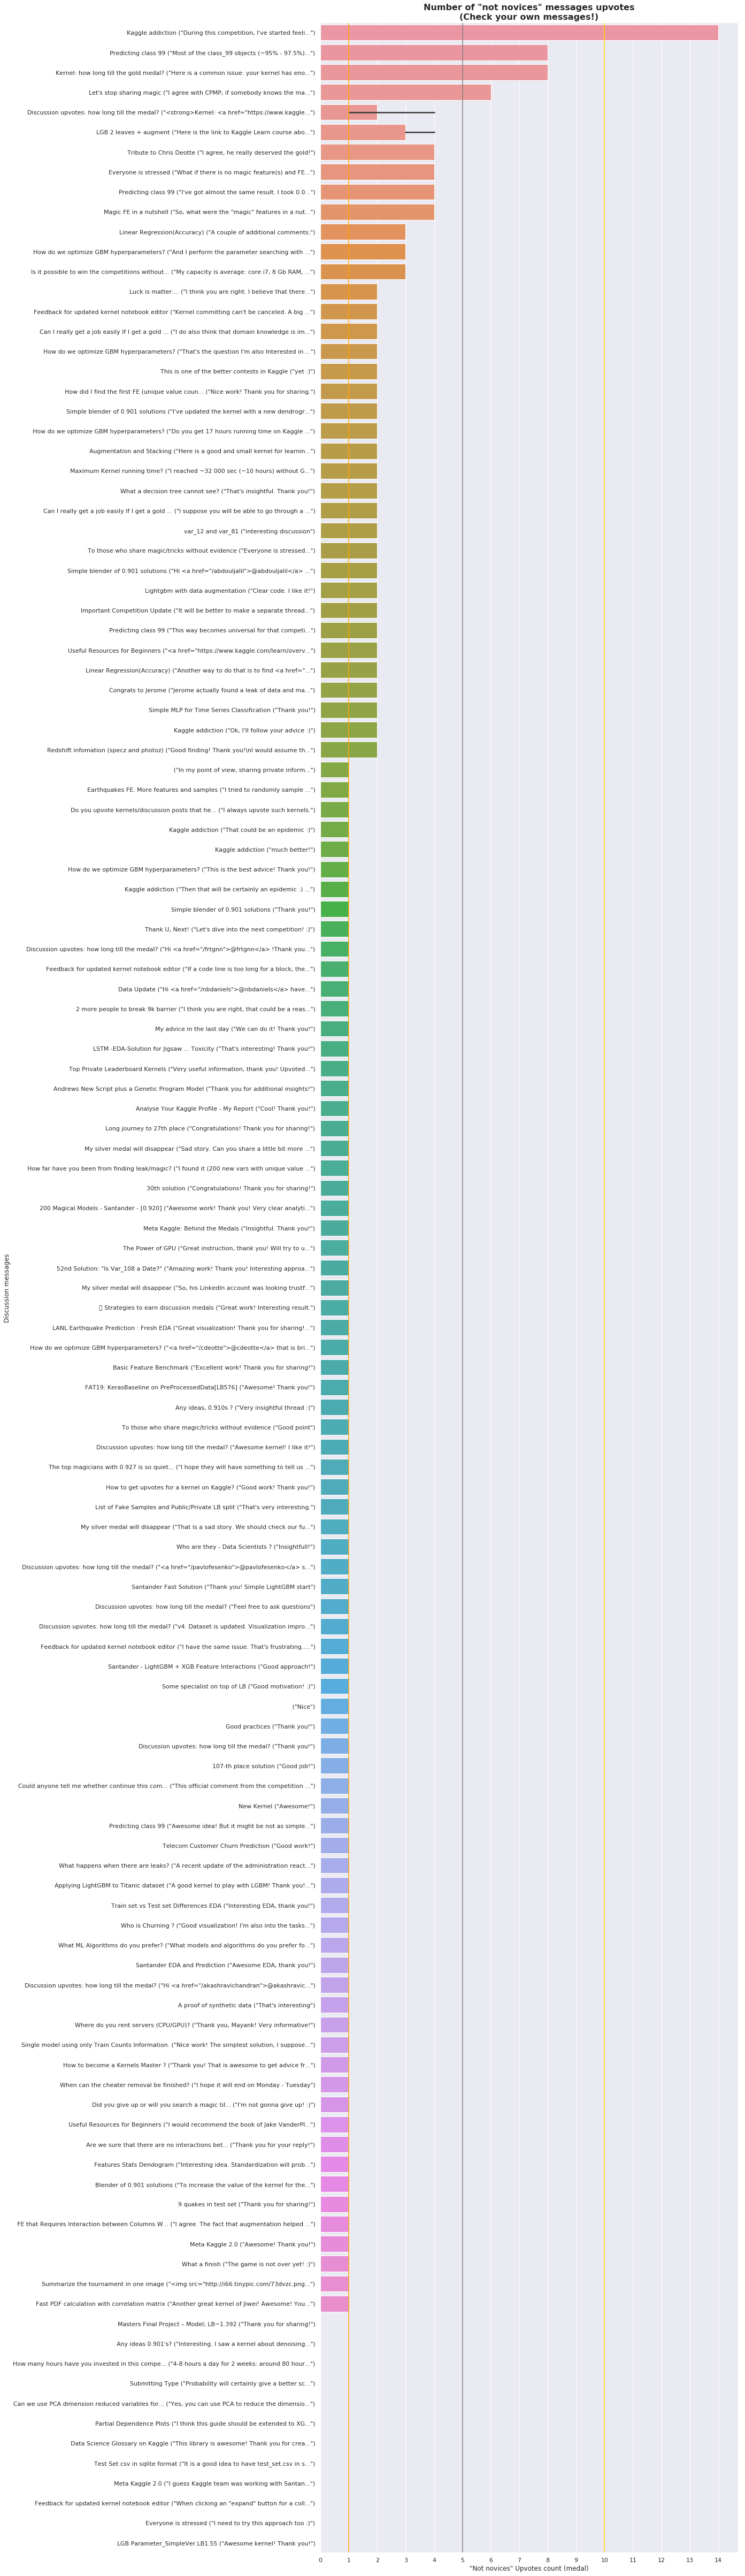

In [4]:
if(message_upvotes[message_upvotes.TotalUpvotes > 0]['MessageId'].count() == 0):
    print("There are no messages with Total Upvotes > 0")
else:
    # plot only messages with upvotes > 0
    graph_vertical_size = message_upvotes[message_upvotes.TotalUpvotes > 0]['MessageId'].count()/1.5
    graph_vertical_size = round(graph_vertical_size, 0)
    plt.figure(figsize = (14, graph_vertical_size))

    sns.barplot(x = 'CountedUpvotes', 
                y = 'DiscussionTopic-Message', 
                data = message_upvotes[message_upvotes.TotalUpvotes > 0].sort_values(by = ['CountedUpvotes'], ascending = False))

    # bronze medal zone
    plt.axvline(x = 1, color = 'orange')
    # silver medal zone
    plt.axvline(x = 5, color = 'grey')
    # gold medal zone
    plt.axvline(x = 10, color = 'gold')

    plt.title('Number of "not novices" messages upvotes\n(Check your own messages!)', 
              {'fontsize':'16', 
               'fontweight':'bold'})

    if(max(message_upvotes.CountedUpvotes) > 10):
        max_tick = max(message_upvotes.CountedUpvotes)+1
    else:
        max_tick = 10+1

    plt.xticks(np.arange(0, max_tick, 1.0))
    plt.ylabel('Discussion messages')
    plt.xlabel('\"Not novices\" Upvotes count (medal)')
    plt.show()